## <div align="center"> YOLOv3 - Object Detection </div>
***

This demo aims to show how to implement YOLOv3 for object detection on any given images that can be found in this Github.

Sections:<a id='sections_yv3'></a>

1. [Environment Setup](#environment_setup_yv3) (incl. import libraries, download weights)

2. [Model Setup](#model_setup_yv3) (incl. load weights, define functions & internal architectures, compile model)

3. [Object Detection Example](#object_detection_example_yv3)

4. [Wrap Up:](#wrap_up_yv3) Discussion & Closing

<br>
NOTE: This notebook is one of the Computer Vision (CV) notebooks, which is designed to focus on Deep Learning models that use in CV areas (e.g. image classification, object detection, object tracking, semantic segmentation, instance segmentation and etc.). Do consider other notebooks if looking for different Deep Learning models approach or examples.
<br>
<br>

### 1. Environment Setup <a id='environment_setup_yv3'></a> 

[Sections](#sections_yv3)

In [1]:
# import libraries
import cv2
import tensorflow as tf

import numpy as np
import plotly.express as px

from absl import logging
from itertools import repeat

In [2]:
# download YOLOv3 weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-08-14 22:25:15--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.2’

yolov3.weights.2    100%[===================>] 236.52M  3.12MB/s    in 64s     

2021-08-14 22:26:20 (3.68 MB/s) - ‘yolov3.weights.2’ saved [248007048/248007048]



### 2. Model Setup <a id='model_setup_yv3'></a> 

[Sections](#sections_yv3)

NOTE: standard YOLOv3 Architecture is used in this example.

##### define parameters

In [3]:
yolo_iou_threshold   = 0.6 # iou threshold
yolo_score_threshold = 0.6 # score threshold

weightsyolov3 = 'yolov3.weights' # path to weights file
weights= 'checkpoints/yolov3.tf' # path to checkpoints file

checkpoints = 'checkpoints/yolov3.tf'

size= 416             #resize images
num_classes = 80      # number of classes in the model

class_names =  [
    "person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana","apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake","chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop",
    "mouse","remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator","book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

##### define YOLOv3 layers

In [4]:
YOLO_V3_LAYERS = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

##### load YOLOv3 weights

In [5]:
def load_darknet_weights(model, weights_file):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    layers = YOLO_V3_LAYERS

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
              sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            logging.info("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)

                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))

            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read weigts'
    wf.close()

##### define functions for calculating intersection

In [6]:
def interval_overlap(interval_1, interval_2):
    x1, x2 = interval_1
    x3, x4 = interval_2
    if x3 < x1:
        return 0 if x4 < x1 else (min(x2,x4) - x1)
    else:
        return 0 if x2 < x3 else (min(x2,x4) - x3)

def intersectionOverUnion(box1, box2):
    intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect_area = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union_area = w1*h1 + w2*h2 - intersect_area
    return float(intersect_area) / union_area

##### define function for drawing bounding box, class name and probability

In [7]:
def draw_outputs(img, outputs, class_names):
    boxes, score, classes, nums = outputs
    boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], score[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

##### define 3 anchor boxes for each grid

In [8]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

##### build API and internal achitectures (e.g. ResNet block) functions

In [9]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
    def call(self, x, training=False):
        if training is None: training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=size,
              strides=strides, padding=padding,
              use_bias=not batch_norm, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    return x

def DarknetResidual(x, filters):
    previous  = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = tf.keras.layers.Add()([previous , x])
    return x


def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in repeat(None, blocks):
        x = DarknetResidual(x, filters)       
    return x


def Darknet(name=None):
    x = inputs = tf.keras.layers.Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)
    x = x_36 = DarknetBlock(x, 256, 8)
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [10]:
def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = tf.keras.layers.Input(x_in[0].shape[1:]), tf.keras.layers.Input(x_in[1].shape[1:])
            x, x_skip = inputs

            x = DarknetConv(x, filters, 1)
            x = tf.keras.layers.UpSampling2D(2)(x)
            x = tf.keras.layers.Concatenate()([x, x_skip])
        else:
            x = inputs = tf.keras.layers.Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_conv

In [11]:
def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = tf.keras.layers.Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = tf.keras.layers.Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output


def yolo_boxes(pred, anchors, classes):
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    score = tf.sigmoid(score)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)

    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

    box_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    return bbox, score, class_probs, pred_box

In [12]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
    boxes, conf, out_type = [], [], []

    for output in outputs:
        boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
        conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
        out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

    bbox = tf.concat(boxes, axis=1)
    confidence = tf.concat(conf, axis=1)
    class_probs = tf.concat(out_type, axis=1)

    scores = confidence * class_probs
  
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=100,
        max_total_size=100,
        iou_threshold=yolo_iou_threshold,
        score_threshold=yolo_score_threshold)
  
    return boxes, scores, classes, valid_detections

In [13]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
            masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = tf.keras.layers.Input([size, size, channels])

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return tf.keras.Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = tf.keras.layers.Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
    boxes_1 = tf.keras.layers.Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
    boxes_2 = tf.keras.layers.Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

    outputs = tf.keras.layers.Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return tf.keras.Model(inputs, outputs, name='yolov3')

In [14]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                      tf.zeros_like(true_wh), true_wh)

        obj_mask = tf.squeeze(true_obj, -1)
        # ignore when Intersection Over Union is over threshold
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(intersectionOverUnion(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = tf.keras.losses.binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss

        class_loss = obj_mask * tf.keras.losses.sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

##### define function to transform inputs into 6 representations: [x, y, w, h, obj, class] of the bounding boxes

In [15]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

    N = tf.shape(y_true)[0]

    y_true_out = tf.zeros(
      (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, classes):
    outputs = []
    grid_size = 13

    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                    (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
    tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        outputs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs, classes))
        grid_size *= 2

    return tuple(outputs) # [x, y, w, h, obj, class]


def preprocess_image(x_train, size):
    return (tf.image.resize(x_train, (size, size))) / 255

##### compile YOLOv3 model

In [16]:
yolo3 = YoloV3(classes=num_classes)

load_darknet_weights(yolo3, weightsyolov3)

yolo3.save_weights(checkpoints)

### 3. Object Detection Example <a id='object_detection_example_yv3'></a>

[Sections](#sections_yv3)

In [17]:
# provide path to input image
image = 'cv_image.jpg'

# open & prep image
img = tf.image.decode_image(open(image, 'rb').read(), channels=3)
img = tf.expand_dims(img, 0)
img = preprocess_image(img, size)

In [18]:
# call YOLOv3
boxes, scores, classes, nums = yolo3(img)

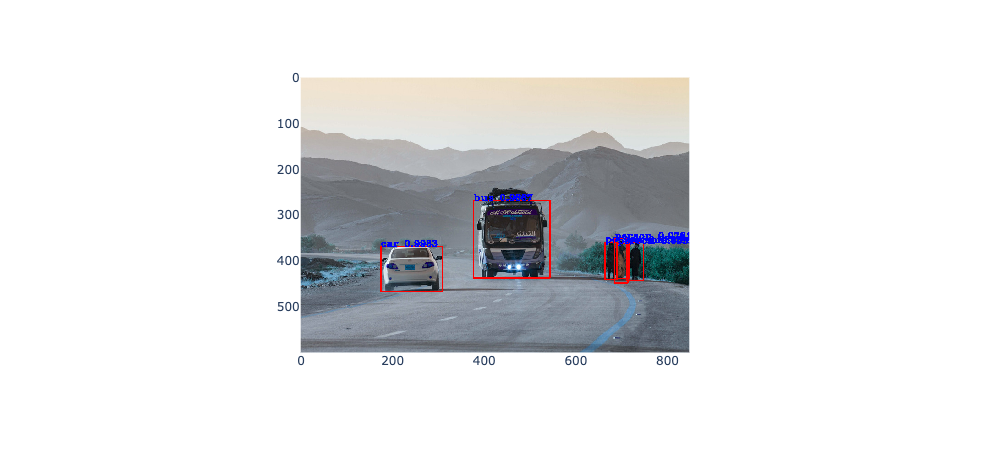

In [19]:
img = cv2.imread(image)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

# save output
cv2.imwrite('cv_image_output.jpg', img)

# plot
fig = px.imshow(img)
fig.show()

### 4. Wrap Up<a id='wrap_up_yv3'></a> 

[Sections](#sections_yv3)

**Discussion & Closing:**

One of the points that is worth mentioning is Transfer Learning (TL), which is widely used in nearly all CV problems. TL is the idea of leveraging a pre-trained model (eps. weights) for a new problem without training the model from scatrch. This idea is particularly useful when solving complex problems for many reasons. Apart from overcoming the issue of insufficient dataset, TL also helps speeding up the deployment of any real-world applications without forgoing too much cost. For these reasons, many new domains with little knowledge and limited resources (e.g. skilled domain experts, a massive supporting dataset, powerful technologies) could now make use of Deep Learning models. For instance, this example has leveraged on the pre-trained models for different uses, thanks to the people who make the tools available for everyone.

To wrap up, the objective of this notebook is to show how to implement YOLOv3 Deep Learning model for Object Detection.